In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
GOLD = pd.read_csv('/home/tumich/Desktop/portfolio/Gold.csv')

In [5]:
BTC = pd.read_csv('/home/tumich/Desktop/portfolio/btc.csv')

In [6]:
SC = pd.read_csv('/home/tumich/Desktop/portfolio/sc.csv')

In [7]:
GOLD['Date'] = pd.to_datetime(GOLD['Date'], utc=True)
GOLD.set_index('Date',inplace=True)

In [8]:
GOLD = GOLD.drop(columns=['Open','High','Low','Close','Volume'])

In [9]:
GOLD.columns = ['Price']

In [10]:
GOLD = GOLD.loc['2019-09-15':'2020-09-15']

In [11]:
BTC = BTC.drop(columns=['market_cap','total_volume'])

In [12]:
BTC.columns = ['Date','Price']

In [13]:
BTC['Date'] = pd.to_datetime(BTC['Date'], utc=True)
BTC.set_index('Date',inplace=True)

In [14]:
BTC = BTC.loc['2019-09-15':'2020-09-15']

In [15]:
SC = SC.drop(columns=['market_cap','total_volume'])

In [16]:
SC.columns = ['Date','Price']

In [17]:
SC['Date'] = pd.to_datetime(SC['Date'], utc=True)
SC.set_index('Date',inplace=True)

In [18]:
SC = SC.loc['2019-09-15':'2020-09-15']

In [19]:
GOLD = GOLD.fillna(method='ffill')
BTC = BTC.fillna(method='ffill')
SC = SC.fillna(method='ffill')

In [20]:
GOLD = GOLD.fillna(method='bfill')

In [21]:
assets = pd.concat([GOLD,BTC,SC],axis=1)
assets.columns = ['GOLD','BTC','SC']

In [22]:
assets.tail()

,GOLD,BTC,SC
Date,,,
2020-09-11 00:00:00+00:00,1937.800049,10342.159391,0.003434
2020-09-12 00:00:00+00:00,1937.800049,10378.223045,0.003499
2020-09-13 00:00:00+00:00,1937.800049,10439.384672,0.003471
2020-09-14 00:00:00+00:00,1953.099976,10328.866066,0.003341
2020-09-15 00:00:00+00:00,1953.099976,10661.096235,0.003492


In [23]:
assets.pct_change(1).mean()

GOLD    0.000774
BTC     0.000812
SC      0.004219
dtype: float64

In [24]:
assets.pct_change(1).corr()

,GOLD,BTC,SC
GOLD,1.000000,0.140342,0.028642
BTC,0.140342,1.000000,0.621220
SC,0.028642,0.621220,1.000000


In [25]:
log_ret = np.log(assets/assets.shift(1))
log_ret.head()

,GOLD,BTC,SC
Date,,,
2019-09-15 00:00:00+00:00,NaN,NaN,NaN
2019-09-16 00:00:00+00:00,0.000000,-0.004249,0.022986
2019-09-17 00:00:00+00:00,0.001330,-0.003621,-0.005579
2019-09-18 00:00:00+00:00,0.001593,-0.006385,0.000375
2019-09-19 00:00:00+00:00,-0.006055,-0.004343,0.044581


In [26]:
assets.pct_change(1).head()

,GOLD,BTC,SC
Date,,,
2019-09-15 00:00:00+00:00,NaN,NaN,NaN
2019-09-16 00:00:00+00:00,0.000000,-0.004240,0.023252
2019-09-17 00:00:00+00:00,0.001331,-0.003615,-0.005564
2019-09-18 00:00:00+00:00,0.001595,-0.006364,0.000375
2019-09-19 00:00:00+00:00,-0.006036,-0.004334,0.045590


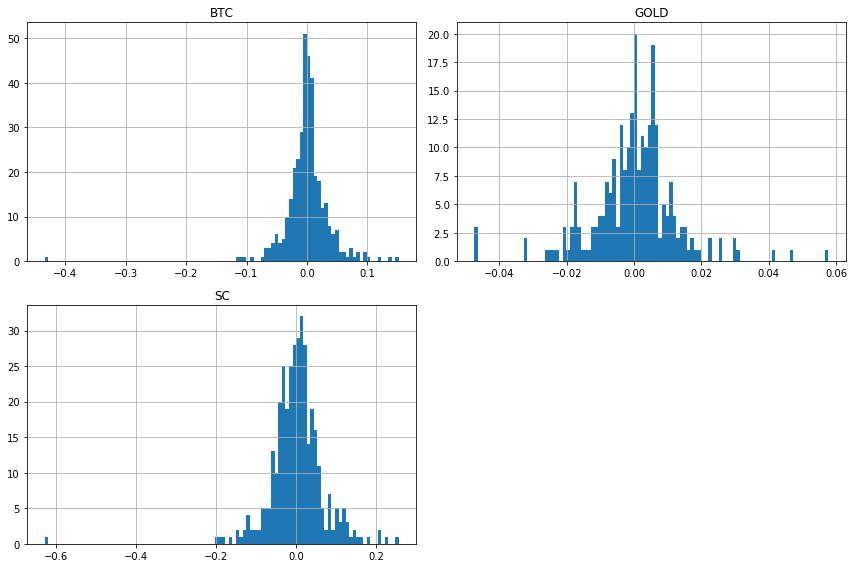

In [27]:
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

In [28]:
log_ret.cov()*365

,GOLD,BTC,SC
GOLD,0.058420,0.035938,0.023878
BTC,0.035938,0.557076,0.678031
SC,0.023878,0.678031,1.770076


In [29]:
log_ret.corr()*365

,GOLD,BTC,SC
GOLD,365.000000,64.833424,24.944442
BTC,64.833424,365.000000,249.223502
SC,24.944442,249.223502,365.000000


In [36]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports,len(assets.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    weights = np.array(np.random.random(3))
    weights = weights/np.sum(weights)
    
    all_weights[ind,:] = weights

    ret_arr[ind] = np.sum((log_ret.mean()*weights)*365)


    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*365,weights)))

    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [37]:
sharpe_arr.max()

0.5435332934256036

In [38]:
sharpe_arr.argmax()

3393

In [39]:
all_weights[3393,:]

array([0.65176964, 0.0014082 , 0.34682216])

In [43]:
max_sr_ret = ret_arr[3393]
max_sr_vol = vol_arr[3393]

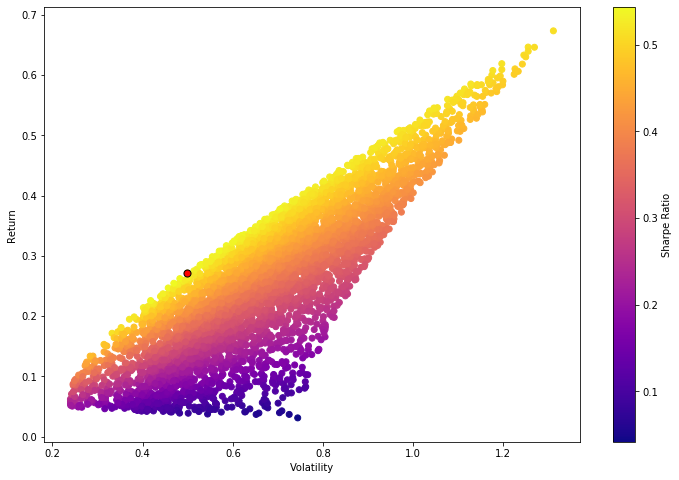

In [46]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black');

In [47]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 365
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*365,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [48]:
from scipy.optimize import minimize

In [49]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]*-1

In [50]:
def check_sum(weights):
    return np.sum(weights) - 1

In [51]:
cons = ({'type':'eq','fun':check_sum})

In [52]:
bounds = ((0,1),(0,1),(0,1))

In [53]:
init_guess = [0.33,0.33,0.34]

In [55]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [56]:
opt_results

     fun: -0.544306359689414
     jac: array([-4.40552831e-05,  5.18743627e-01,  8.69557261e-05])
 message: 'Optimization terminated successfully.'
    nfev: 53
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([6.63761477e-01, 2.51860165e-16, 3.36238523e-01])

In [57]:
opt_results.x

array([6.63761477e-01, 2.51860165e-16, 3.36238523e-01])

In [58]:
get_ret_vol_sr(opt_results.x)

array([0.2647116 , 0.48632832, 0.54430636])

In [59]:
frontier_y = np.linspace(0,0.7,100)

In [60]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [62]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
           {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

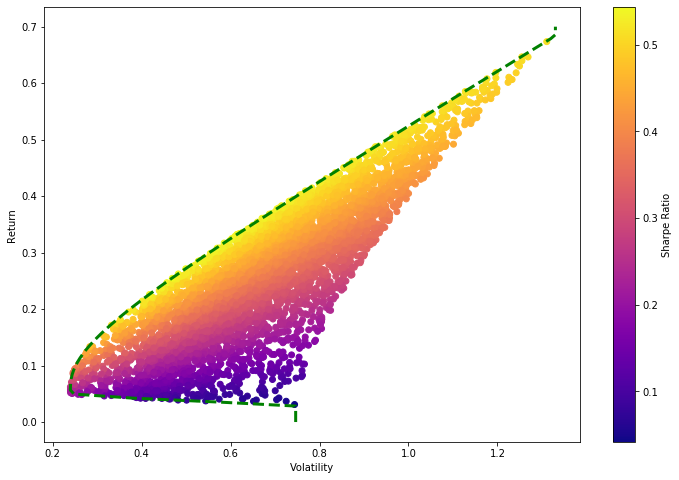

In [70]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return');

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3);